# Исследование гипотез увеличения выручки интернет-магазина

<div style="border:solid green 2px; padding: 20px">


<b>Закачик</b> - Интернет-магазин
    
<b>Описание исследования:</b>

<b>Цель</b> - Исследовать гипотезы увеличения выручки, сформированные отделом маркетинга, в целях их принятия или опровержения. Формирование рекомендаций для планирования дальнейшей деятельности заказчика.
    
<b>Задачи исследования:</b> 
- Приоритизация сформированных гипотез;
- Анализ результатов A/B теста;
- Формирование рекомендаций.
    
<b>Данные</b> - Для исследования заказчиком предоставлены следующие данные:

_Таблица hypothesis (сформированные гипотезы):_
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

_Таблица orders (информация о заказах):_
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

_Таблица visitors (информация о посетителях):_
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Подготовка к исследованию

In [1]:
# импортирую все библиотеки, которые могут понадобиться в ходе исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
from math import factorial
import statsmodels.api as sm
from datetime import datetime, timedelta
import scipy.stats as stats

In [2]:
# отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
# помощь в отображении данных
pd.set_option('display.max_columns', None) # отображение всех столбцов
pd.set_option('display.max_colwidth', None) # отображение данных в столбцах, даже если они слишком длинные
pd.set_option("display.float_format", "{:.2f}".format) # избавляюсь от экспоненциальной записи

In [4]:
# загружаю исследуемые таблицы
# использую try / except для оптимизации перехода с работы на платформе на локальный режим
try:
    hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                                    pd.read_csv('/datasets/orders.csv'),
                                    pd.read_csv('/datasets/visitors.csv'))
except:
    hypothesis, orders, visitors  = (pd.read_csv('../Downloads/hypothesis.csv'),
                                     pd.read_csv('../Downloads/orders.csv'),
                                     pd.read_csv('../Downloads/visitors.csv'))

## Знаконство с данными и их предобработка
### Таблица гипотез

In [5]:
# знакомство с таблицей hypothesis
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Все столбцы имеют корректный формат данных. В целях избежания ошибок о опечаток в последующей работе приведу название столбцов к нижнему регистру.

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Таблица заказов

In [7]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [8]:
# вызов информации о таблице orders
orders.info()
orders.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [9]:
# вызов информации о пропусках в таблице orders
print('Информация о пропусках в данных о заказах')
orders.isna().sum()

Информация о пропусках в данных о заказах


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

В целом, с таблицей тоже все в порядке, пропусков нет, но необходимо привести к нужному формату столбец с информацией о дате заказа (date), и привести название колонок нижнему регистру.

In [10]:
orders['date'] = pd.to_datetime(orders['date'])
orders.columns = orders.columns.str.lower()
orders.describe().T

,count,mean,std,min,25%,50%,75%,max
transactionid,1197.00,2155621385.53,1229084904.76,1062393.00,1166775572.00,2145193898.00,3237740112.00,4293855558.00
visitorid,1197.00,2165960143.10,1236014192.15,5114589.00,1111826046.00,2217984702.00,3177606451.00,4283872382.00
revenue,1197.00,8348.01,39191.13,50.00,1220.00,2978.00,8290.00,1294500.00


При ближайшем рассмотрении таблицы с данными о заказах, в глаза бросается разброс выручки: минимальное значение 50, а максимальное свыше 1 млн., что, также, в несколько раз превышает медианное значение. В данных есть выбросы и этот момент нужно будет учитывать при анализе A/B-теста.

Согласно описанию данных, в таблице содержится информация о принадлежности к группе А или В. Для верности дальнейшего исследования, проверю, есть ли пользователи, которые попали в обе группы, перед этим проверив на наличие явных дубликатов.

In [11]:
orders.duplicated().sum()  # подсчёт явных дубликатов 

0

In [12]:
double_users = np.intersect1d(orders.query('group == "A"')['visitorid'].unique(),
               orders.query('group == "B"')['visitorid'].unique()) 
print('Количество совпадений:', len(double_users))

Количество совпадений: 58


58 пользователей попали в обе группы теста. Чтобы избежать ошибок в анализе его результатов, избавлюсь от пересечений.

In [13]:
# избавление о пересечений
orders = orders[~orders['visitorid'].isin(double_users)]  

# проверка результатов очистки
double_users_2 = np.intersect1d(orders.query('group == "A"')['visitorid'].unique(),
                                  orders.query('group == "B"')['visitorid'].unique()) 
print('Количество совпадений после очистки:', len(double_users_2))

Количество совпадений после очистки: 0


Данные очищены от задвоений. Дубликатов нет, посмотрю как распределяются группы.

In [14]:
display(orders.groupby('group').agg({'visitorid': 'count'}))
orders.pivot_table(index = 'group', values = 'revenue', aggfunc = ('mean','median'))

,visitorid
group,
A,468
B,548


,mean,median
group,,
A,7189.44,3090.00
B,9249.95,2898.50


Численность группы B выше, чем численность группы A.

Если опираться на средние показатели выручки, то в группе B она выше, но если же смотреть на медианное значение, то выше выручка по группе A. Возможно в группе B большее число выбросов со сверхдорогими покупками. Проверю предположение графически.

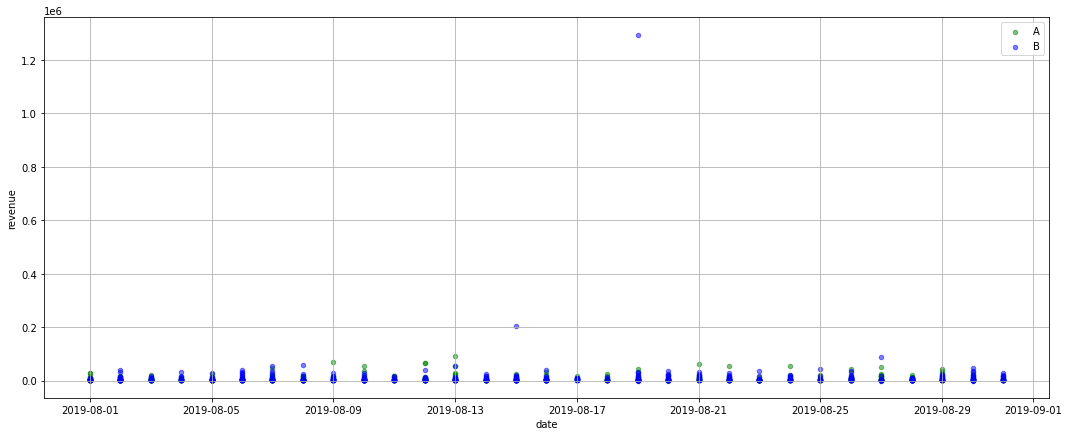

In [15]:
ax = orders.query('group == "A"').plot(kind='scatter', x='date', y='revenue', color='green', 
                 alpha = 0.5, grid=True, figsize=(18, 7), label='A');


orders.query('group == "B"').plot(kind='scatter', x='date', y='revenue', color='blue', 
            alpha = 0.5, grid=True, figsize=(18, 7), label='B', ax=ax);


Действительно, 2 выброса (один из которых - это внушительная покупка на 1,2 млн) принадлежат группе B.

На данном этапе завершу знакомство и обработку таблицы с данными о заказах.

### Таблица поселитетей

In [16]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [17]:
# вызов информации о таблице visitors
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
# вызов информации о пропусках в таицебл visitors
print('Информация о пропусках в данных о посетителях')
visitors.isna().sum()

Информация о пропусках в данных о посетителях


date        0
group       0
visitors    0
dtype: int64

С данными также все в порядке, но необходимо изменить формат столбца с данными о дате посещения интернет-магазина.

In [19]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [20]:
visitors.duplicated().sum()  # подсчёт явных дубликатов 

0

Явные дубликаты отсутсвуют. Проверю распределение по группам.

In [21]:
visitors.groupby('group').agg({'visitors': 'sum'})

,visitors
group,
A,18736
B,18916


In [22]:
total_a = visitors.query('group == "A"')['visitors'].sum()
total_b = visitors.query('group == "B"')['visitors'].sum()
print('Разница между группами А и В составляет:', abs(total_a - total_b))

Разница между группами А и В составляет: 180


Число посетителей по группам разделены примерно одинаково, группа B больше на 180 посетителей.

### Вывод по этапу
<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">
Я внимательно ознакомилась с данными и провела следующие этапы их предобработки:
    
- столбцы с датами приведены к нужному формату
- названия столбцов теперь указаны в нижнем регистре
- проведена проверка на явные дубликаты
- таблица с заказами очищена от пользователей, попавших в обе группы.
- познакомилась с данными поближе, изучив данные о выбросах.
    
На данном этапе работа по знакомству с данными завершена, приступаю к непосредственному анализу для заказчика.    

## Приоретизация гипотез

### Приоретизация гипотез с использованием фреймворка ICE

In [23]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.30
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.30
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.10
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


<b>Вывод:</b>

Согласно выполненным рассчетам лидируют 3 гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения - 16,2
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - 13,3
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - 11,2

Немного отстают от них, но все равно имеют больший показатель по ICE еще 2 гипотезы:
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию - 8,0
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - 7,0

При этом интересно отметить, что гипотеза **_Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей_**, в свою очередь, согласно impact повлияет на всех пользователей, их опыт и удовлетворение от продукта.

Лидирующая гипотеза **_Запустить акцию, дающую скидку на товар в день рождения_** имеет очень высокие значения impact и confidence - 9, и с точки зрения уверенности в том, что данная гипотеза увеличит выручку, имеет наивысший бал из лидеров.

Все три лидирующие гипотезы примерно одинаково тестировать.

### Приоретизация гипотез с использованием фреймворка RICE

In [24]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.30,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.10,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.30,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


<b>Вывод:</b>

Ситуация иная, по отношению к предыдущему выводу. На фоне остальных явно можно выделить 4 гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - 112,0
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - 56,0
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - 40,0
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию - 40,0

Лидер предыдещего расчета **_Запустить акцию, дающую скидку на товар в день рождения_** занимает лишь 5 позицию со значением RICE 16,0

3 из 4-х лидирующих гипотез были в топ-4 при испрользовании фреймворка ICE:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - занимала 3 позицию
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - занимала 2 позицию
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию - сохранила ту же 4 позицию.

Гипотеза **_Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа_**, что сейчас на второй позиции была на 5 и не критически отставала от топ-4.

### Вывод по этапу
<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">
    
На основании выполненных расчетов можно следать выводы, что самыми перспективными с точки зрения влияния на увеличение выручки заказчика, будут следующие гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок 
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей 
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию 
    
Легче всего протестировать вторую гипотезу в этом списке (efforts - 3). Оставшиеся гипотезы тестировать примерно одинаково - 5 и 6 efforts для первой и третьей позиций соответсвенно.     
    
Основные отличия рейтингов можно объяснить следующими моментами:
- Гипотезе _Запустить акцию, дающую скидку на товар в день рождения_ не удалось сохранить высокие показатели перспективности по фреймворкe RICE  из-за низкого показателя reach - изменение охватывает минимальное число пользователей.    
- Гипотеле _Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок_ напротив из-за максимального значения reach - 10 - удалось занять первую позицию. Эта же гипотеза, по мнению отдела маркетинга, с большой долей уверенности (confidence - 8) повлиет на рост выручки.
- Гипотеза _Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей_ держит место в обоих рейтингах наиболее перспективных гипотез за счет максимального значения impact, что означает, что по мнению маркетологов, введение этого изменения максимально повлияет на пользователей, их опыт и удовлетворение от продукта.

**Самые не перспективные гипотезы и почему:**
- _Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей_ - затрагивает минимальное число пользователей, практически не влияет на пользовательский опыт и удовлетворенность от продукта и совсем не внушает уверенности, хоть и имеет наименьшую стоимость для тестирования.   
- _Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов_ - ситуация примерно такая же, как и с гипотезой о смене цвета, но показатели совсем немного выше.  
- _Запустить собственную службу доставки, что сократит срок доставки заказов_ - самая дорогая для тестирования гипотеза - 10 по confidence -  при этом имеет весьма низкий покатель уверенности в том, что изменение повлияет на увеличение выручки, к тому же, охватыввает минимальное число пользователей.
- _Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар_ - гипотеза дорогая для тестирования, не внушает особой уверенности у маркетологов, и имеет невысокий показатель влияния на пользовательские опыт  

## Анализ A/B-теста

### Кумулятивная выручка по группам

In [25]:
# создаю массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаю агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and
                                       (orders['date'] <= x['date'],orders['group'] == x['group'])]
                                        .agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique'
                                        , 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1)
                                        .sort_values(by=['date','group'])
)

# получаю агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and
                                         (visitors['date'] <= x['date'],visitors['group'] == x['group'])]
                                          .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                                          .sort_values(by=['date','group'])
)

# объединяю кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)



,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Необходимый для построения графиков датафрейм собран. Построю график кумулятивной выручки по группам.

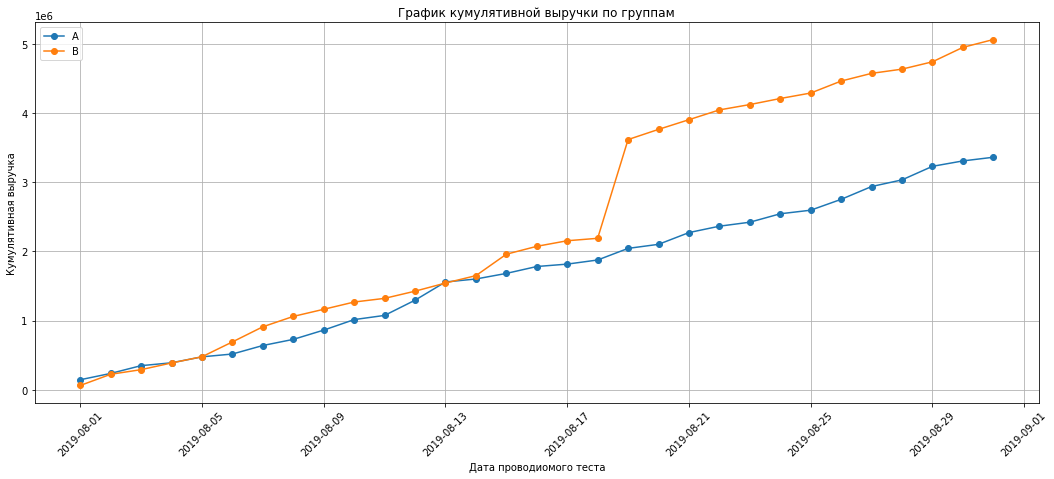

In [26]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим графики
plt.figure(figsize=(18, 7))
#  график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], 'o-', label='A')

# график выручки группы B

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], 'o-', label='B')


plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Дата проводиомого теста')
plt.ylabel('Кумулятивная выручка')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.show();

На графиках наблюдается постепенный и регулярный рост выручки, однако в середине графика по группе теста В наблюдается резкий скачок выручки. Ранее я уже определила, что в районе 19 числа был сделан сверхдорогой (аномальный) заказ. Вероятнее всего на графике кумулятивной выручки скачок связан именно с ним.


### Кумулятивный средний чек

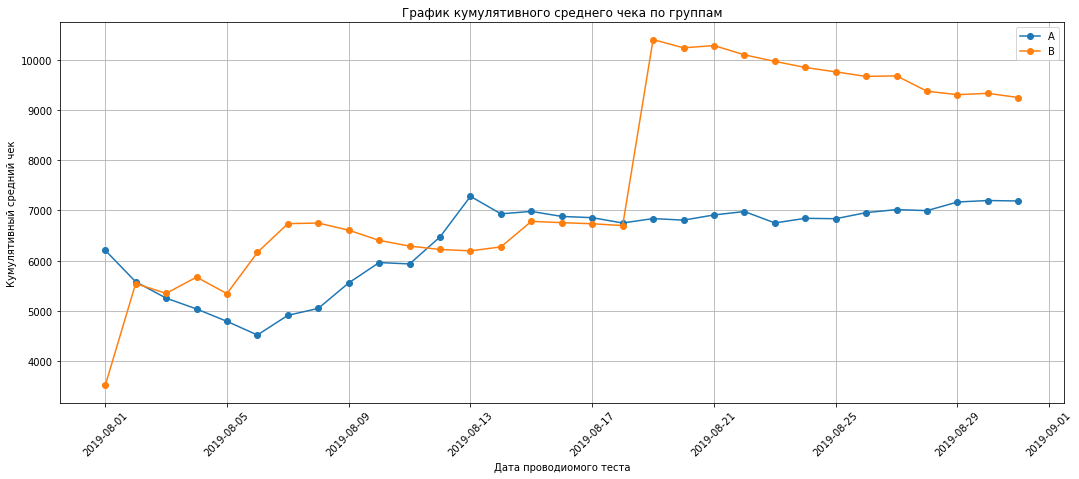

In [27]:
plt.figure(figsize=(18, 7))
# график кумулятивного среднего чека по группе А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 'o-', label='A')

# график кумулятивного среднего чека по группе В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 'o-', label='B')

plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Дата проводиомого теста')
plt.ylabel('Кумулятивный средний чек')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.show();

**Группа А**

Начиная с 13 числа,средний чек по группе А держится на одном уровне, примерно 7000 у.е. При этом с 1 по 6 наблюдается снижение размера среднего чека. После 6 числа стабильный рост и выравнивание на отметке +-7000 от 18 числа и до конца теста.

**Группа В**

В самом начале графика реский рост размера среднего чека. После 9 числа заметен "ломаный" рост до 18-го и 19-го резкий взлет значения среднего чека. После 19 наблюдается плавное снижение. В данном случае, предполагаю, скачок связан с заказам на 1,2 млн. у.е.

### Относительное изменение кумулятивного среднего чека группы B к группе A

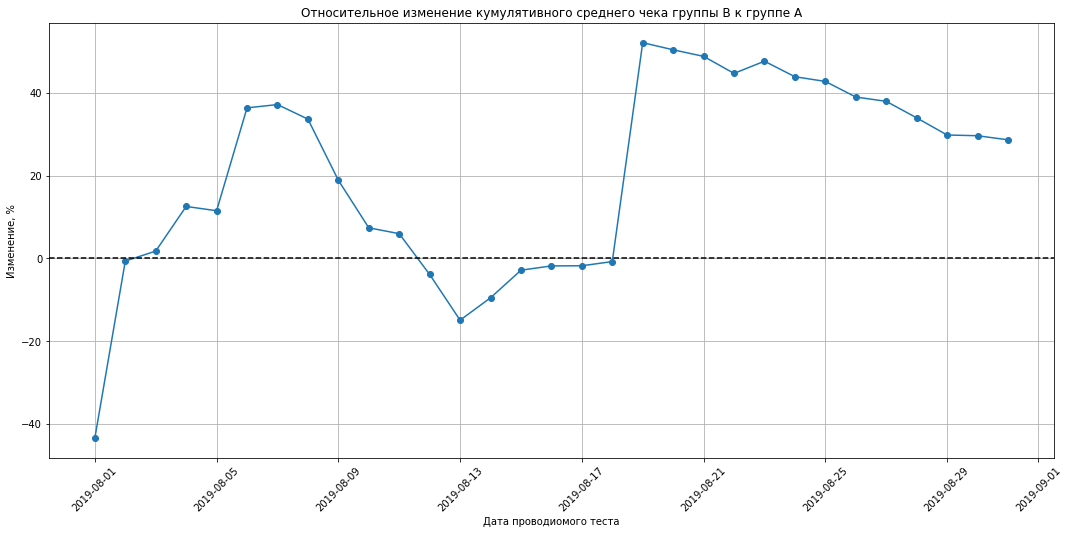

In [28]:
# собираю данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтрою отношение средних чеков
plt.figure(figsize=(18, 8))
plt.plot(mergedCumulativeRevenue['date']
         , ((mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1) * 100, 'o-')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Дата проводиомого теста')
plt.ylabel('Изменение, %')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show();

Резкие скачки говорят о наличии выбросов, таких, как заказ, оформленный 19-го числа пользователем, включенным в группу В. После данного скачка, кумулятивный средний чек по группе В выше, чем по группе А почти на 40%.

### Кумулятивная конверсия по группам

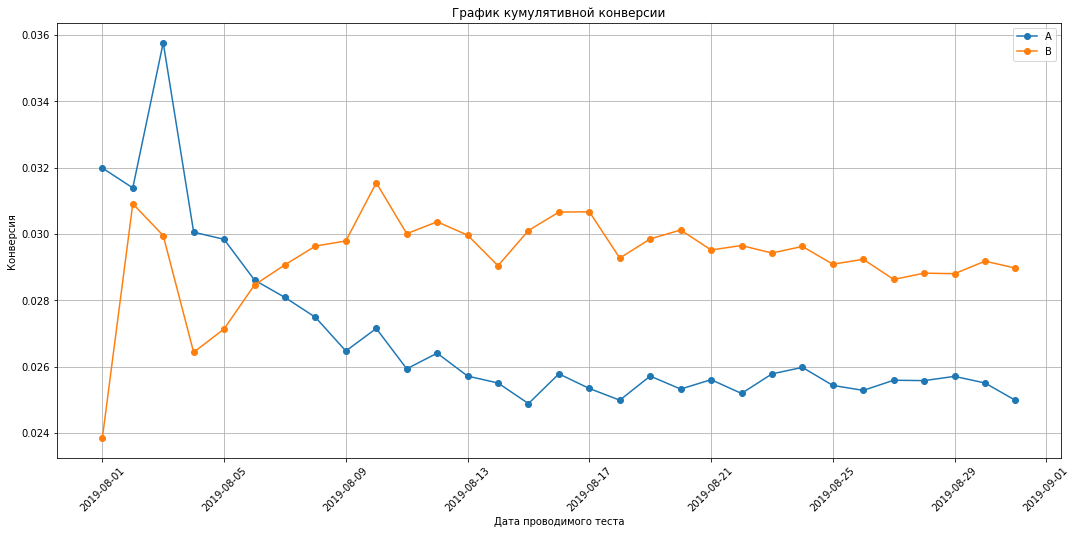

In [29]:
# расчет кумулятивной конверсии
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяю данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяю данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строю графики
plt.figure(figsize=(18, 8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], 'o-', label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], 'o-', label='B')

plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Дата проводимого теста')
plt.ylabel('Конверсия')
plt.title('График кумулятивной конверсии')
plt.legend()
plt.show();

Несмотря на скачки в первые дни теста и явное преимущество конверсии группы А перед группой В примерно к 9-му числу она выровнялась и уже до самого конца теста конверсия по группе В была выше конверсии по группе А.

### Относительное изменение кумулятивной конверсии группы B к группе A

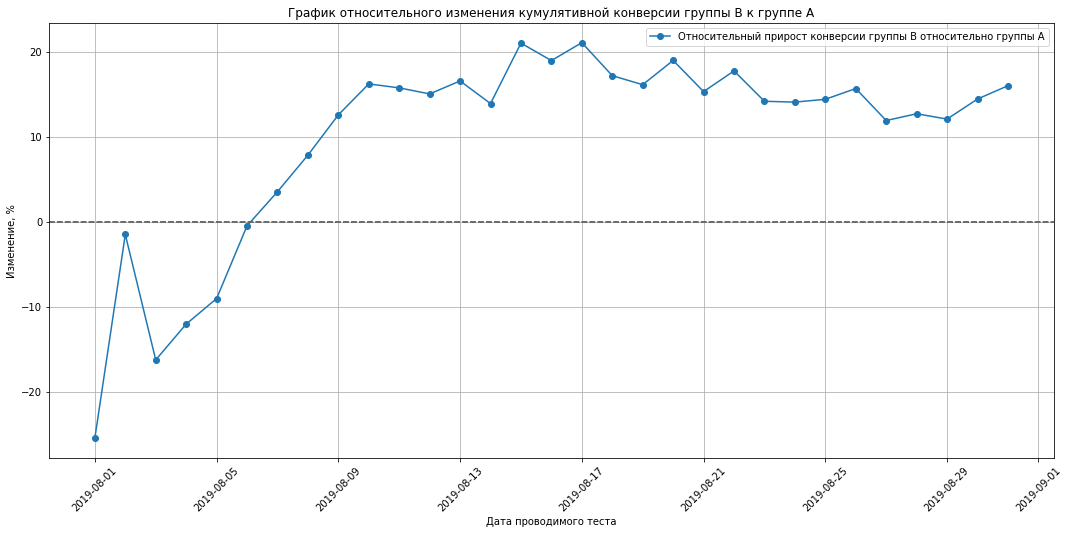

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']]
                                                                           , left_on='date'
                                                                           , right_on='date'
                                                                           , how='left'
                                                                           , suffixes=['A', 'B'])
plt.figure(figsize=(18, 8))
plt.plot(mergedCumulativeConversions['date'], (mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1)*100, 'o-'
         , label="Относительный прирост конверсии группы B относительно группы A")

plt.grid()
plt.xticks(rotation=45)
plt.xlabel('Дата проводимого теста')
plt.ylabel('Изменение, %')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.show();

Как видно на графике относительного изменения кумулятивной конверсии, в самом начале конверсия группы B (несмотря на скачок 2го числа) проигрывала конверсии группы А. Уже после 6го числа конверсия по группе В стала показывать стабильный рост, обойдя конверсию группы А, и примерно с 14 числа выровнялась и показывала стабильно лучший показатель. Превосходство над конверсией по группе А примерно 12-19%.

### Количества заказов по пользователям

In [31]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

ordersByUsers.columns = ['user_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


_Максимальное число заказов на 1 пользователя_ - 3. Таких пользователей всего 7. 

Для того чтобы лучше понимать самое популярное число заказов на 1 пользователя, построю гистограмму.



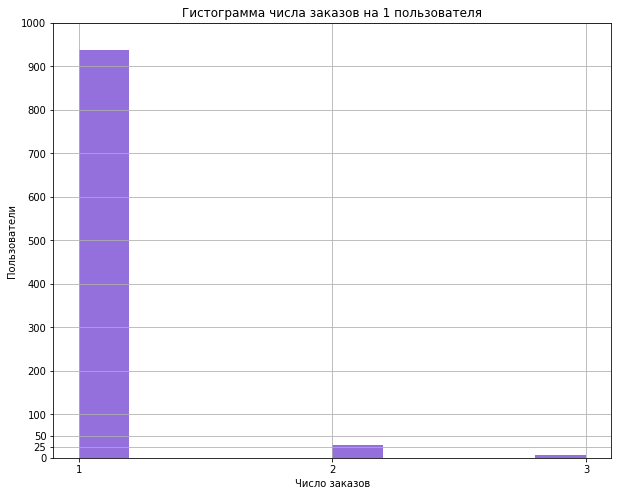

In [32]:
plt.figure(figsize=(10, 8))
plt.hist(ordersByUsers['orders'], color='MediumPurple')

plt.grid()
plt.xticks([1, 2, 3])
plt.yticks([0, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlabel('Число заказов')
plt.ylabel('Пользователи')
plt.title('Гистограмма числа заказов на 1 пользователя')
plt.show(); 

- Свыше 900 пользователей за время теста сделали тольй 1 заказ
- Примерно 25 пользователей сделали 2 заказа
- 7 пользователей сделали 3 заказа.

Изучу распределение числа заказов на точечном графике.

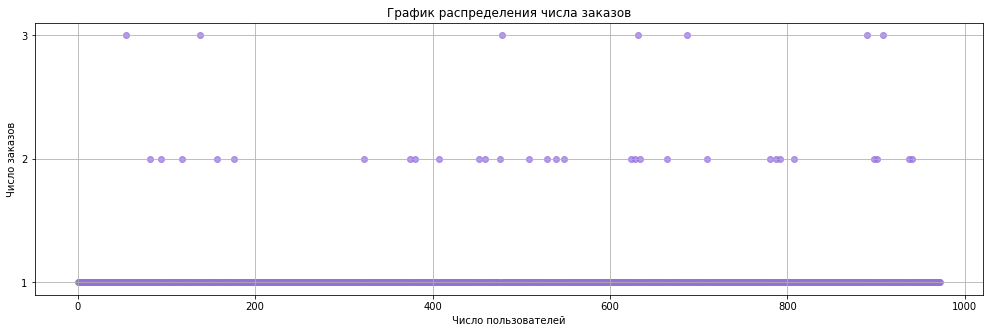

In [33]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(17, 5))
plt.scatter(x_values, ordersByUsers['orders'], color='MediumPurple', alpha=0.7)

plt.grid()
plt.yticks([1, 2, 3])
plt.xlabel('Число пользователей')
plt.ylabel('Число заказов')
plt.title('График распределения числа заказов')
plt.show(); 

График хорошо отображает распределение, визуально видно какую долю от общего числа занимают пользователи, совершившие по 2 или 3 заказа.

Для того чтобы принять решение являются ли, выпадающие из общей массы пользователей, покупатели, совершившие по 2 и 3 покупки, аномалиями, необходимо посчитать перцентили количества заказов на пользователя.

### Перцентили количества заказов на пользователя

In [34]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Число пользователей, совершавших 2 заказа составляет не более 1%. На этом основании, пользователей, сделавших более 1 заказа, можно принять за аномалии.

### Распределение стоимостей заказов

На этапе предобработки и знакомства с данными, я уже строила график подобный распределения стоимости заказов. Построю его еще раз, но уже после предобработки.

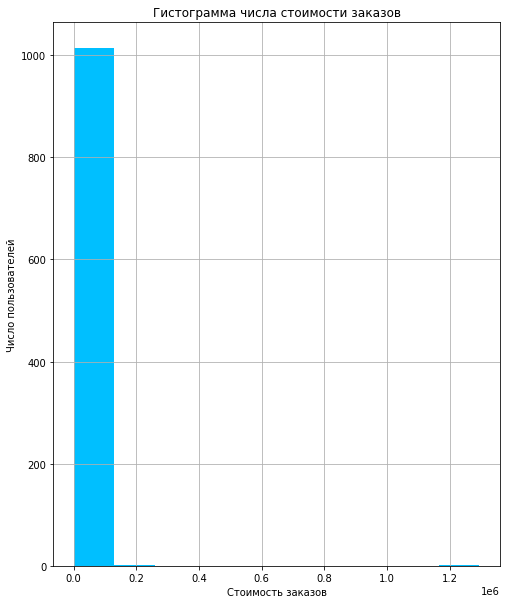

In [35]:
plt.figure(figsize=(8, 10))
plt.hist(orders['revenue'], color='DeepSkyBlue')

plt.grid()
plt.xlabel('Стоимость заказов')
plt.ylabel('Число пользователей')
plt.title('Гистограмма числа стоимости заказов')
plt.show(); 

Очень слабо и затруднительно, но все же можно увидеть, что есть 2 выбивающихся значения стоимости заказов.

Построю точечный график распределения.

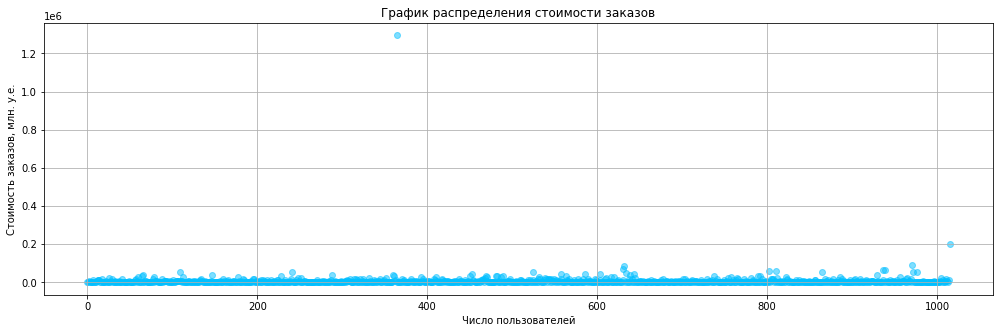

In [36]:
x_values = pd.Series(range(0,len(orders)))

plt.figure(figsize=(17, 5))
plt.scatter(x_values, orders['revenue'], color='DeepSkyBlue', alpha=0.5)

plt.grid()
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов, млн. у.е.')
plt.title('График распределения стоимости заказов')
plt.show(); 

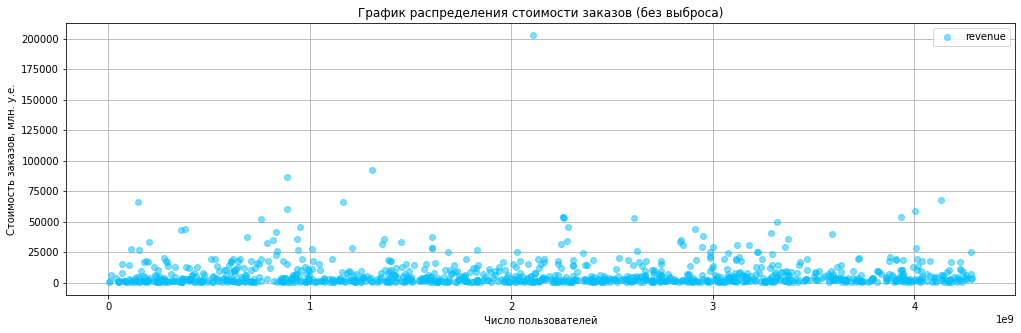

In [37]:
orders.query('revenue < 500000').plot(x = 'visitorid', y = 'revenue', style='o'
                                      , color='DeepSkyBlue', figsize=(17, 5), alpha=0.5)

plt.grid()
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов, млн. у.е.')
plt.title('График распределения стоимости заказов (без выброса)')
plt.show(); 

Заказ в 1,2 млн. у.е.так сильно повлияли на график, что, например, заказ стоимостью в 200 тыс. слился с остальными. Согласно приближенному графику, чаще всего совершают заказы примерно на 10 - 15 тысяч у.е.

Как и в случае с числом заказов, для того чтобы принять уверенное решение об аномалиях в данных, необходимо посчитать перцентили.

### Перцентили стоимости заказов

In [38]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Менее 5% пользователей совершают заказы, стоимостью 26785 у.е. и выше. И всего 1% совершают заказы стоимостью 53904 у.е.
Приму за нижнюю границу заказы стоимостью до 26 000 у.е. Все что выше - аномальные данные на выброс.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Подготовка данных к исследованию.

In [39]:
# ПОСЕТИТЕЛИ

# дневное число посетителей в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# дневное кумулятивное число посетителей в группе А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

# присвоение корректных названий столбцам
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


# дневное число посетителей в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# дневное кумулятивное число посетителей в группе В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

# присвоение корректных названий столбцам
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [40]:
# ЗАКАЗЫ

# дневное число заказов в группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)

# присвоение наименований столбцам
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# кумулятивное число заказов в группе А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

# присвоение наименований столбцам
ordersACummulative.columns = ['date','ordersCummulativeA', 'revenueCummulativeA']

# дневное число заказов в группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)

# присвоение названий столбцам
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# кумулятивное число заказов в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

# присвоение наименований столбцам
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [41]:
# Формирование данных для исследования
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Получившаяся таблица имеет следующие столбцы:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Далее, для того чтобы посчитать статистическую значимость различия в среднем количестве заказов между группами, создам переменные ordersByUsersA и ordersByUsersB со столбцами `['user_id', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, будет указано число совершённых заказов в каждой из групп.

In [42]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsersB.columns = ['user_id', 'orders'] 

ordersByUsersB.head()

,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Готово. 

Далее необходимо объвить переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы выполненить проверку критерием Манна-Уитни.

При проведении проверки критерием Манна-Уитни буду использовать уровень статистической значимости 0.05.

Сформирую нулевые гипотезы, которые необходимо подтвердить или опровергнуть (гипотезы сформированы от равенства):
1. Различий между конверсиями в группах А и В нет.
2. Разницы между размерами средних чекаов в группах А и В нет.

Альтернативные гипотезы звучат так:
1. Конверсии групп А и В различны.
2. Средний чек в группах А и В различны.


In [43]:
[ordersByUsersA['orders'],pd.Series(0
                                    , index=np.arange(data['visitorsPerDateA']
                                                      .sum() - len(ordersByUsersA['orders'])), name='orders')] 

sampleA = pd.concat([ordersByUsersA['orders']
                     ,pd.Series(0, index=np.arange(data['visitorsPerDateA']
                                                   .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders']
                     ,pd.Series(0, index=np.arange(data['visitorsPerDateB']
                                                   .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


**Промежуточный вывод**
<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">

По «сырым» данным различия в среднем числе заказов групп A и B есть.
Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, _отвергаем_. 

Также, согласно сырым данным, конверсия группы В больше конверсии по группе А на 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [44]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue']
                                          , orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                       /orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


**Промежуточный вывод**
<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">

P-value значительно больше 0.05 и составляет 0.829. Это говорит о том, что  причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но при этом, средний чек по группе В выше, чем средний чек по группе А почти на 29%.

Для того чтобы лучше понимать полученные результаты теста, нужно повторить расчеты по данным, очищенным от выбросов.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Ранее, в ходе исследования, я определила нижние границы "хороших" данных:
- пользователи выболнившие **_не более 1 заказа_**, то есть меньше 2 заказов
- заказы стоимостью **_не более 26 000 у.е._**

In [45]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

568     113298937
1099    148427295
461     154576532
928     204675465
33      249864742
dtype: int64

61


Всего в данных 61 аномалия - менее 1%, казалось бы немного, но тот же же заказ на 1,2 млн. сильно влиял на ранее выполненные расчеты. Теперь можно проверить, как выбросы действиетльно повлияли на статистические значимости.

Как и в этапе ранее, необходимо подготовить выборки по группам теста, но уже с очищенными данными. Выборки задам в переменных `sampleAFiltered` и `sampleBFiltered`.

In [46]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Теперь можно применить к выборкам статистический критерий Манна-Уитни.

In [47]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.013
0.180


**Промежуточный вывод**
<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">
    
Ощутимых изменений нет. p-value все еще меньше 0.05, следовательно и в этот раз нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, _отвергаем_. 

А по очищенным данным конверсия группы В еще больше больше конверсии по группе А - в этот раз уже на 18%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [48]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.615
-0.056


**Промежуточный вывод**
<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">
    
По по среднему чеку ситуация уже другая.

P-value снова значительно больше 0.05, но меньше, чем по "сырым" данным - 0.615. Это снова говорит о том, что отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

Но интересная ситуация по среднему чеку. По очищенным данным, средний чек по группе В меньше среднего чека по группе А примерно на 5,5%, хотя ранее лидировал почти на 29%. Это хорошо отобразает как сверхдорогая покупка влияла на всю картину в целом.


### Принятие решений по итогу анализа теста

<div style="border:solid DeepSkyBlue 0.5px; padding: 10px">

**Число заказов**

_Сырые данные_
- p-value - 0.011. Отвергнуть гипотезу, что статистически значимых различий в среднем числе заказов между группами можно.
- конверсия группы В больше конверсии группы А на 16%.

_Очищенные данные_
- p-value - 0.013. Гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.
- конверсия группы В больше конверсии группы А на 18%.

**Стоимость заказов**

_Сырые данные_
- p-value - 0.829. Отвергнуть гипотезу, то в среднем чеке по группам есть различия, нельзя.
- средний чек по группе В больше среднего чека по группе А почти на 29%.

_Очищенные данные_
- p-value - 0.615. Отвергнуть гипотезу, то в среднем чеке по группам есть различия, нельзя.
- средний чек по группе В меньше среднего чека по группе А почти на 6%.

**Общий вывод по итогу анализа теста**
Тест необходимо остановить и призназнать успешным. 

- Статистически значимое различие по среднему количеству заказов между группами по «сырым» данным есть.
- После фильтрации от аномалий статистически значимое различие по среднему количеству заказов между группами есть.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
- После фильтрации средний чек по группе А стал выше среднего чека по группе В.

Группа В лучше конвертируется, но несколько уступает по среднему чеку, при этом изменение незначительное. Также стоит отметить, что аномально дорогие заказы (как показывал график), в основном принадлежат пользователям из группы В.

## Общий вывод

<div style="border:solid green 0.5px; padding: 10px">

<font color='Indigo'>**Приритезация гипотез**</font>

В рамках выполнения работы по приоритезации гипотез уведичения выручки, сформированных отделом маркетинга заказчика (интеренет-магазина), были выполнены расчеты с применением фреймворка `ICE` и фреймворка `RICE`. По итогам обеих расчетов были сформированы перечни самых перспективных и самых не перспективных гипотез, с объяснением причин, влияющих на место в рейтинге.

_**Самые перспективные гипотезы**_

- _Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок_ (максимальный охват пользователей, дает высокий показатель уверенности в положительном влиянии на выручку, имеет среднюю стоимость теста и довольно высокий показатель влияния на пользовательский опыт).
- _Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей_ (максимальное влияние на пользовательский опыт, высокий уровень уверенности в том, что гипотеза сработает, средняя стоимость теста)
- _Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию_ (высокий уровень уверенности и низкая стоимость теста).

_**Самые не перспективные гипотезы**_

- _Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей_ (затрагивает минимальное число пользователей, практически не влияет на пользовательский опыт и удовлетворенность от продукта и совсем не внушает уверенности, хоть и имеет наименьшую стоимость для тестирования)   
- _Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов_ (затрагивает небольшое число пользователей, мало влияет на пользовательский опыт и удовлетворенность от продукта и не внушает уверенности, хоть и имеет наименьшую стоимость для тестирования) 
- _Запустить собственную службу доставки, что сократит срок доставки заказов_ ( максимальная стоимость тестирования гипотеза, имеет весьма низкий покатель уверенности в том, что изменение повлияет на увеличение выручки, охватывает минимальное число пользователей).
- _Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар_ (дорогая для тестирования, не внушает особой уверенности , и имеет невысокий показатель влияния на пользовательские опыт).

<font color='Indigo'>**Анализ А/В - теста**</font>

_**Данные**_

Перед анализом данные были изучены и предобрапотаны. Для корректного анализа теста были удалены пользователи, попавшие в обе группы теста.

_**Расчеты по "сырым" и отлильтрованным данным**_

- Статистически значимое различие по среднему количеству заказов между группами по «сырым» данным есть.
- После фильтрации от аномалий статистически значимое различие по среднему количеству заказов между группами есть.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
- После фильтрации средний чек по группе А стал выше среднего чека по группе В.

_**Предложение по итогу анализа A/B теста**_

Тест остановить и признать успешным. Анализ показал, что группа В конвертируется лучше, при этом по отфильтрованным данным, превосходсво среднего чека по группе А незначительное. Но превосходство среднего чека по группе В при "сырых" данных - 29%. По результатам теста можно зафиксировать превосходство группы В.